# Обнаружение статистически значимых отличий в уровнях экспрессии генов больных раком

Это задание поможет вам лучше разобраться в методах множественной проверки гипотез и позволит применить ваши знания на данных из реального биологического исследования.

## В этом задании вы:

- вспомните, что такое t-критерий Стьюдента и для чего он применяется
- сможете применить технику множественной проверки гипотез и увидеть собственными глазами, как она работает на реальных данных
- почувствуете разницу в результатах применения различных методов поправки на множественную проверку

## Основные библиотеки и используемые методы:

Библиотека scipy и основные статистические функции:http://docs.scipy.org/doc/scipy/reference/stats.html#statistical-functions

Библиотека statmodels для методов коррекции при множественном сравнении:

http://statsmodels.sourceforge.net/devel/stats.html

Статья, в которой рассматриваются примеры использования statsmodels для множественной проверки гипотез:

http://jpktd.blogspot.ru/2013/04/multiple-testing-p-value-corrections-in.html

## Описание используемых данных

Данные для этой задачи взяты из исследования, проведенного в Stanford School of Medicine. В исследовании была предпринята попытка выявить набор генов, которые позволили бы более точно диагностировать возникновение рака груди на самых ранних стадиях.

В эксперименте принимали участие 24 человек, у которых не было рака груди (normal), 25 человек, у которых это заболевание было диагностировано на ранней стадии (early neoplasia), и 23 человека с сильно выраженными симптомами (cancer).
<img src="img/task1_img1.png">

Ученые провели секвенирование биологического материала испытуемых, чтобы понять, какие из этих генов наиболее активны в клетках больных людей.

Секвенирование — это определение степени активности генов в анализируемом образце с помощью подсчёта количества соответствующей каждому гену РНК.

В данных для этого задания вы найдете именно эту количественную меру активности каждого из 15748 генов у каждого из 72 человек, принимавших участие в эксперименте.

Вам нужно будет определить те гены, активность которых у людей в разных стадиях заболевания отличается статистически значимо.

Кроме того, вам нужно будет оценить не только статистическую, но и практическую значимость этих результатов, которая часто используется в подобных исследованиях.

Диагноз человека содержится в столбце под названием "Diagnosis".

Практическая значимость изменения

Цель исследований — найти гены, средняя экспрессия которых отличается не только статистически значимо, но и достаточно сильно. В экспрессионных исследованиях для этого часто используется метрика, которая называется **fold change** (кратность изменения). Определяется она следующим образом:

<img src="img/task1_img2.png">
где C,T — средние значения экспрессии гена в control и treatment группах соответственно. По сути, **fold change** показывает, во сколько раз отличаются средние двух выборок.

## Инструкции к решению задачи

Задание состоит из **трёх** частей. Если не сказано обратное, то уровень значимости нужно принять равным 0.05.

### Часть 1: применение t-критерия Стьюдента

В первой части вам нужно будет применить критерий Стьюдента для проверки гипотезы о равенстве средних в двух независимых выборках. Применить критерий для каждого гена нужно будет дважды:

1. для групп **normal (control)** и **early neoplasia (treatment)**
2. для групп **early neoplasia (control)** и **cancer (treatment)**

В качестве ответа в этой части задания необходимо указать количество статистически значимых отличий, которые вы нашли с помощью t-критерия Стьюдента, то есть число генов, у которых p-value этого теста оказался меньше, чем уровень значимости.

In [9]:
import numpy as np
import pandas as pd
import scipy
from statsmodels.stats.weightstats import *

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
def to_write_ansver(ans, question_num):
    '''
    Запись ответа ans в файл с номером question_num
    '''
    with open('ansvers/task1_ans_{}.txt'.format(question_num), 'w') as f:
        f.write(str(ans))

In [2]:
data = pd.read_csv('data/gene_high_throughput_sequencing.csv')

In [3]:
data.head()

,Patient_id,Diagnosis,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
0,STT5425_Breast_001_normal,normal,1.257614,2.408148,13.368622,9.494779,20.880435,12.722017,9.494779,54.349694,...,4.761250,1.257614,1.257614,1.257614,1.257614,1.257614,23.268694,1.257614,1.257614,1.257614
1,STT5427_Breast_023_normal,normal,4.567931,16.602734,42.477752,25.562376,23.221137,11.622386,14.330573,72.445474,...,6.871902,1.815112,1.815112,1.815112,1.815112,1.815112,10.427023,1.815112,1.815112,1.815112
2,STT5430_Breast_002_normal,normal,2.077597,3.978294,12.863214,13.728915,14.543176,14.141907,6.232790,57.011005,...,7.096343,2.077597,2.077597,2.077597,2.077597,2.077597,22.344226,2.077597,2.077597,2.077597
3,STT5439_Breast_003_normal,normal,2.066576,8.520713,14.466035,7.823932,8.520713,2.066576,10.870009,53.292034,...,5.200770,2.066576,2.066576,2.066576,2.066576,2.066576,49.295538,2.066576,2.066576,2.066576
4,STT5441_Breast_004_normal,normal,2.613616,3.434965,12.682222,10.543189,26.688686,12.484822,1.364917,67.140393,...,11.227770,1.364917,1.364917,1.364917,1.364917,1.364917,23.627911,1.364917,1.364917,1.364917


In [4]:
data.shape

(72, 15750)

In [6]:
data['Diagnosis'].value_counts()

early neoplasia    25
normal             24
cancer             23
Name: Diagnosis, dtype: int64

проверим нормальность 'LOC643837' в группах `normal` и `early neoplasia` визуально через Ку-ку график

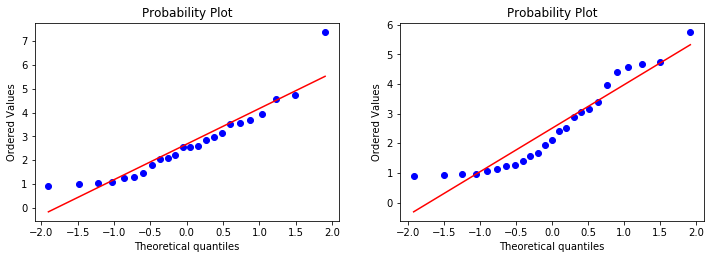

In [16]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
stats.probplot(data['LOC643837'][data['Diagnosis'] == 'normal'], dist="norm", plot=plt)
plt.subplot(2,2,2)
stats.probplot(data['LOC643837'][data['Diagnosis'] == 'early neoplasia'], dist="norm", plot=plt)
plt.show()

In [43]:
pv_norm_early = np.array([scipy.stats.ttest_ind(data[gene][data['Diagnosis'] == 'normal'], 
                                                data[gene][data['Diagnosis'] == 'early neoplasia'], equal_var = False).pvalue 
                          for gene in data.drop(['Patient_id', 'Diagnosis'], axis=1).columns])

n_diff_1 = (pv_norm_early < 0.05).sum()
n_diff_1

1575

In [44]:
pv_early_cancer = np.array([scipy.stats.ttest_ind(data[gene][data['Diagnosis'] == 'early neoplasia'], 
                                                data[gene][data['Diagnosis'] == 'cancer'], equal_var = False).pvalue 
                          for gene in data.drop(['Patient_id', 'Diagnosis'], axis=1).columns])

n_diff_2 = (pv_early_cancer < 0.05).sum()
n_diff_2

3490

In [45]:
to_write_ansver(n_diff_1, 1.1)
to_write_ansver(n_diff_2, 1.2)

### Часть 2: поправка методом Холма

Для этой части задания вам понадобится модуль **multitest** из statsmodels.

`import statsmodels.stats.multitest as smm`

В этой части задания нужно будет применить поправку Холма для получившихся двух наборов достигаемых уровней значимости из предыдущей части. Обратите внимание, что поскольку вы будете делать поправку для каждого из двух наборов p-value отдельно, то проблема, связанная с множественной проверкой останется.

Для того, чтобы ее устранить, достаточно воспользоваться поправкой Бонферрони, то есть использовать уровень значимости 0.05 / 2 вместо 0.05 для дальнейшего уточнения значений p-value c помощью метода Холма.

В качестве ответа к этому заданию требуется ввести количество значимых отличий в каждой группе после того, как произведена коррекция Холма-Бонферрони. Причем это число нужно ввести с учетом практической значимости: посчитайте для каждого значимого изменения fold change и выпишите в ответ число таких значимых изменений, абсолютное значение fold change которых больше, чем 1.5.

**Обратите внимание, что**

- применять поправку на множественную проверку нужно **ко всем значениям достигаемых уровней значимости, а не только для тех, которые меньше значения уровня доверия.**
- при использовании поправки на уровне значимости 0.025 **меняются значения достигаемого уровня значимости, но не меняется значение уровня доверия **(то есть для отбора значимых изменений скорректированные значения уровня значимости нужно сравнивать с порогом 0.025, а не 0.05)!

In [41]:
import statsmodels.stats.multitest as smm

Сделаем Датафрейм, где будем считать и куда будем складывать ответы

In [49]:
data_pv = pd.DataFrame(data.drop(['Patient_id', 'Diagnosis'], axis=1).columns, columns=['Genes'] )

In [48]:
reject, p_corrected, a1, a2 = smm.multipletests(pv_norm_early, alpha=0.05/2, method='holm')

In [51]:
data_pv['pv_norm_early'] = pv_norm_early
data_pv['pv_norm_early_CORR'] = p_corrected
data_pv['pv_norm_early_reject'] = reject

In [52]:
data_pv.head()

,Genes,pv_norm_early,pv_norm_early_CORR,pv_norm_early_reject
0,LOC643837,0.690766,1.000000,False
1,LOC100130417,0.000032,0.500174,False
2,SAMD11,0.060273,1.000000,False
3,NOC2L,0.826429,1.000000,False
4,KLHL17,0.049876,1.000000,False


Вычислим список генов, по которым равенство средних отвергнуто с учетом новых вводных, то есть с учетом поправок Бенфероони-Холма

In [58]:
list_reject = data_pv['Genes'][data_pv['pv_norm_early_reject']]
list_reject

7244     PCSK4
9820    EEF1A2
Name: Genes, dtype: object

In [65]:
# см. пояснения в инструкции к заданию
def fold_change(C, T):
    return T / C if T > C else -(C / T)

Сгруппируем по исследуемым группам ('Diagnosis') и посчитаем средние для всех генов по каждой из групп

In [79]:
groupby = data.groupby(by='Diagnosis').mean()
groupby

,LOC643837,LOC100130417,SAMD11,NOC2L,KLHL17,PLEKHN1,C1orf170,HES4,ISG15,AGRN,...,CLIC2,RPS4Y1,ZFY,PRKY,USP9Y,DDX3Y,CD24,CYorf15B,KDM5D,EIF1AY
Diagnosis,,,,,,,,,,,,,,,,,,,,,
cancer,2.186060,8.190456,23.692614,16.468034,25.035813,13.870940,9.677439,67.162763,91.706112,73.359613,...,4.684026,2.539207,2.168508,2.669397,1.871647,2.292908,15.752268,2.157294,2.776173,1.985272
early neoplasia,2.510894,8.721781,18.531325,15.071854,24.152469,10.793160,9.009031,64.670644,37.296084,75.707467,...,5.720618,1.956668,2.075279,2.057353,1.794432,1.961449,17.567902,1.760707,2.151549,1.727730
normal,2.681277,4.368497,15.159566,15.374351,21.459886,9.374537,8.105567,58.080871,34.983861,62.870812,...,6.242498,2.104486,1.662368,1.842830,1.525062,1.701654,17.106405,1.576004,1.960442,1.568210


Дополним критерий значимостью отличий (модуль `fold change` > 1.5) и посчитаем количество генов, для которых это выполняется. Запишем ответ

In [77]:
C, T = 'normal', 'early neoplasia'
n_significant_diff_1 = (np.array([abs(fold_change(groupby.loc[C, gene], groupby.loc[T, gene])) 
                                  for gene in list_reject]) > 1.5).sum()
n_significant_diff_1

2

In [78]:
to_write_ansver(n_significant_diff_1, 2.1)

**Проделаем все то же самое для групп `early neoplasia` и `cancer`**

In [81]:
reject, p_corrected, a1, a2 = smm.multipletests(pv_early_cancer, alpha=0.05/2, method='holm')
data_pv['pv_early_cancer_reject'] = reject
list_reject = data_pv['Genes'][data_pv['pv_early_cancer_reject']]

C, T = 'early neoplasia', 'cancer'
n_significant_diff_2 = (np.array([abs(fold_change(groupby.loc[C, gene], groupby.loc[T, gene])) 
                                  for gene in list_reject]) > 1.5).sum()

to_write_ansver(n_significant_diff_2, 2.2)
n_significant_diff_2

77

## Часть 3: поправка методом Бенджамини-Хохберга

Данная часть задания аналогична второй части за исключением того, что нужно будет использовать метод Бенджамини-Хохберга.

Обратите внимание, что методы коррекции, которые контролируют FDR, допускает больше ошибок первого рода и имеют большую мощность, чем методы, контролирующие FWER. Большая мощность означает, что эти методы будут совершать меньше ошибок второго рода (то есть будут лучше улавливать отклонения от **$H_0$**, когда они есть, и будут чаще отклонять **$H_0$**, когда отличий нет).

В качестве ответа к этому заданию требуется ввести количество значимых отличий в каждой группе после того, как произведена коррекция Бенджамини-Хохберга, причем так же, как и во второй части, считать только такие отличия, у которых `abs(fold change) > 1.5`.

_P.S. Вспомните, какое значение имеет уровень значимости α в каждой из поправок: Холма и Бенджамини-Хохберга. Одинаковый ли смысл имеет уровень значимости в каждой из поправок?_

In [85]:
reject, p_corrected, a1, a2 = smm.multipletests(pv_norm_early, alpha=0.05/2, method='fdr_bh')
data_pv['pv_norm_early_fdr_bh_reject'] = reject
list_reject = data_pv['Genes'][data_pv['pv_norm_early_fdr_bh_reject']]

C, T = 'normal', 'early neoplasia'
n_significant_diff_fdr_bh_1 = (np.array([abs(fold_change(groupby.loc[C, gene], groupby.loc[T, gene])) 
                                  for gene in list_reject]) > 1.5).sum()

to_write_ansver(n_significant_diff_fdr_bh_1, 3.1)
n_significant_diff_fdr_bh_1

4

In [86]:
reject, p_corrected, a1, a2 = smm.multipletests(pv_early_cancer, alpha=0.05/2, method='fdr_bh')
data_pv['pv_early_cancer_fdr_bh_reject'] = reject
list_reject = data_pv['Genes'][data_pv['pv_early_cancer_fdr_bh_reject']]

C, T = 'early neoplasia', 'cancer'
n_significant_diff_fdr_bh_2 = (np.array([abs(fold_change(groupby.loc[C, gene], groupby.loc[T, gene])) 
                                  for gene in list_reject]) > 1.5).sum()

to_write_ansver(n_significant_diff_fdr_bh_2, 3.2)
n_significant_diff_fdr_bh_2

524